# Machine Learning Assignment 2 (part I) Stella Siu, Jan Kokowski, Tiantian Zhang

##### This code is based on the code provided by The TensorFlow Authors (2020).
https://www.tensorflow.org/tutorials/audio/simple_audio

# Simple audio recognition: Recognizing keywords

##### Codes are retained for this ipynb (tutorial removed to save space); code optimization is commentted on and sometimes with explanation paragraphs.

## Setup

Import necessary modules and dependencies.

In [73]:
#!pip install -U -q tensorflow tensorflow_datasets

In [74]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

## Import the mini Speech Commands dataset

In [75]:
import os
import tensorflow as tf

# Get the current working directory of the Jupyter Notebook (I do it locally.)
current_dir = os.getcwd()

# Set the custom directory for downloading and extracting the dataset
data_dir = tf.keras.utils.get_file(
    fname='mini_speech_commands.zip',
    origin='http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip',
    extract=True,
    cache_dir=current_dir  # Set the cache directory to the current directory
)

# Update data_dir to point to the extracted folder
data_dir = os.path.join(current_dir, 'datasets', 'mini_speech_commands_extracted','mini_speech_commands')

print(f"Dataset is downloaded and extracted to: {data_dir}")


Dataset is downloaded and extracted to: /Users/jankokowski/Desktop/Voice_Technology/Term_1B/Machine_learning/Assignment_2/datasets/mini_speech_commands_extracted/mini_speech_commands


In [76]:
# Check where the dataset is
print(f"Checking directory contents at: {data_dir}")

Checking directory contents at: /Users/jankokowski/Desktop/Voice_Technology/Term_1B/Machine_learning/Assignment_2/datasets/mini_speech_commands_extracted/mini_speech_commands


The dataset's audio clips are stored in eight folders corresponding to each speech command: `no`, `yes`, `down`, `go`, `left`, `up`, `right`, and `stop`:

In [77]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[(commands != 'README.md') & (commands != '.DS_Store')]
print('Commands:', commands)

Commands: ['right' 'go' 'no' 'left' 'stop' 'up' 'down' 'yes']


Divided into directories this way, you can easily load the data using `keras.utils.audio_dataset_from_directory`.

The audio clips are 1 second or less at 16kHz. The `output_sequence_length=16000` pads the short ones to exactly 1 second (and would trim longer ones) so that they can be easily batched.

In [78]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=64,
    validation_split=0.2,
    seed=0,
    output_sequence_length=16000,
    subset='both')

label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)

Found 8000 files belonging to 8 classes.
Using 6400 files for training.
Using 1600 files for validation.

label names: ['down' 'go' 'left' 'no' 'right' 'stop' 'up' 'yes']


The dataset now contains batches of audio clips and integer labels. The audio clips have a shape of `(batch, samples, channels)`.

In [79]:
train_ds.element_spec

(TensorSpec(shape=(None, 16000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

This dataset only contains single channel audio, so use the `tf.squeeze` function to drop the extra axis:

In [80]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

In [81]:
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

In [82]:
for example_audio, example_labels in train_ds.take(1):
  print(example_audio.shape)
  print(example_labels.shape)

(64, 16000)
(64,)


Let's plot a few audio waveforms:

In [83]:
label_names[[1,1,3,0]]

array(['go', 'go', 'no', 'down'], dtype='<U5')

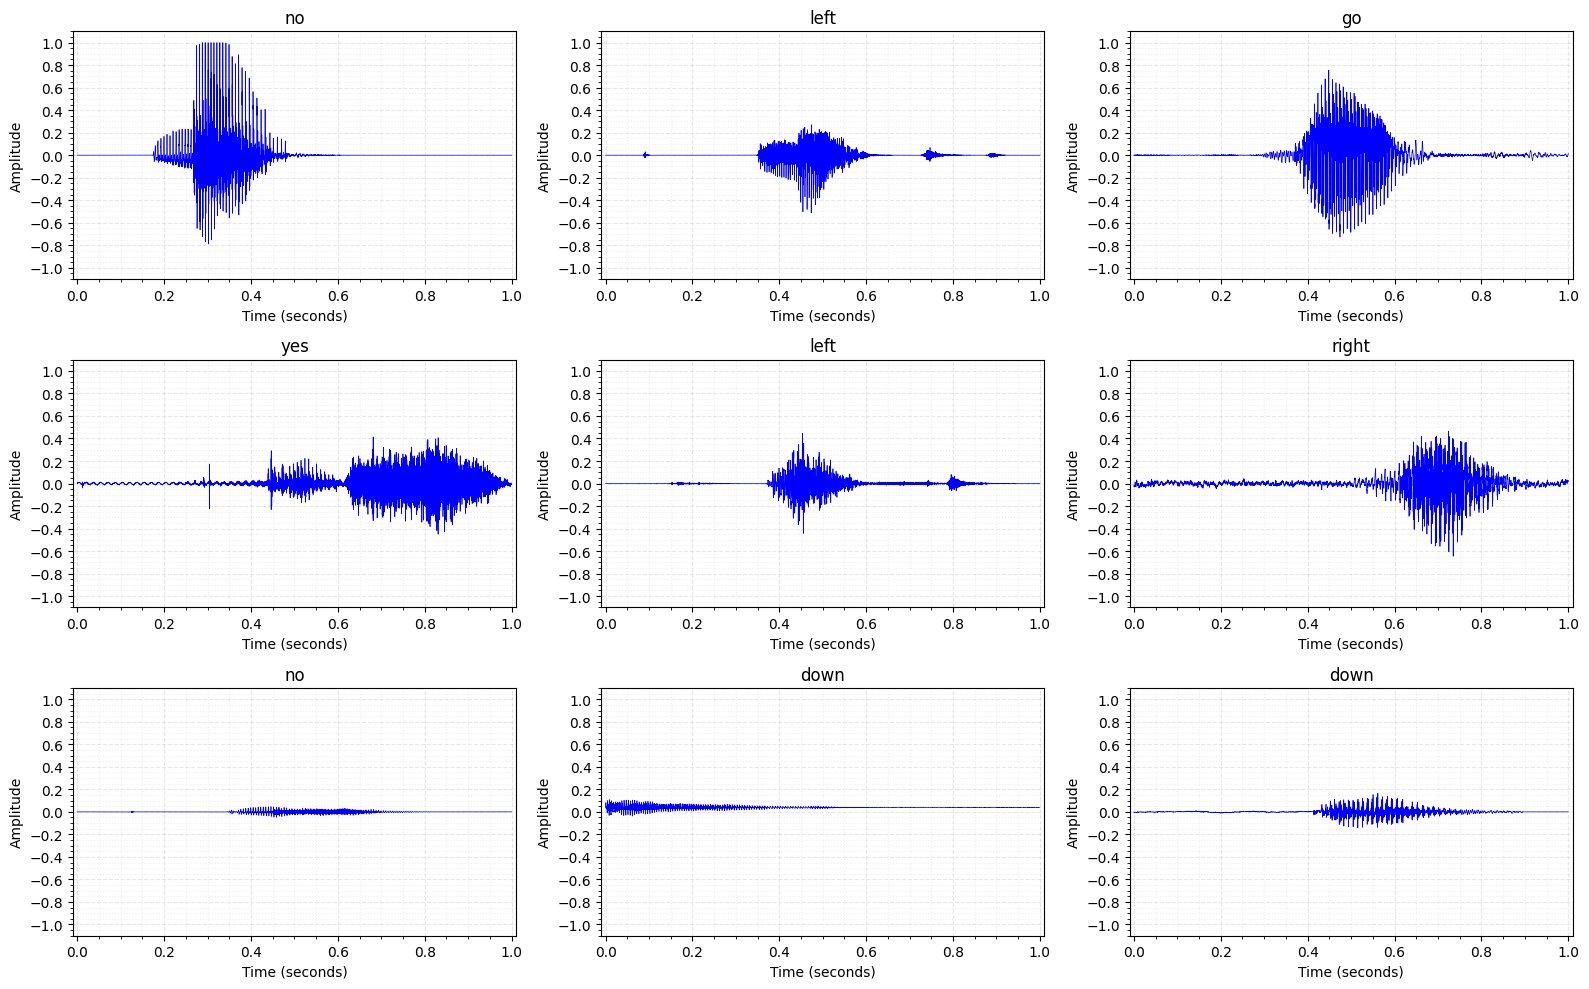

In [84]:
plt.figure(figsize=(16, 10))
rows = 3
cols = 3
n = rows * cols

for i in range(n):
    plt.subplot(rows, cols, i+1)
    audio_signal = example_audio[i+1].numpy()  # Changed i to i+1 to skip the first sample in the batch which could have weaker or less defined waveforms
    
    # Calculate time axis in seconds (assuming 16kHz sample rate)
    sample_rate = 16000
    time = np.arange(len(audio_signal)) / sample_rate
    
    plt.plot(time, audio_signal, linewidth=0.5, color='blue', alpha=1.0)
    plt.title(label_names[example_labels[i+1]])  # Changed i to i+1
    
    plt.xlabel('Time (seconds)')
    plt.ylabel('Amplitude')
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.yticks(np.arange(-1.2, 1.2, 0.2))
    plt.ylim(-1.1, 1.1)
    plt.minorticks_on()
    plt.grid(True, which='minor', linestyle=':', alpha=0.2)
    plt.margins(x=0.01)

plt.tight_layout()
plt.show()

In [85]:
def get_spectrogram(waveform):
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=256, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

Exploring the data. Printing the shapes of one example's tensorized waveform and the corresponding spectrogram, and playing the original audio:

In [86]:
for i in range(3):
  label = label_names[example_labels[i]]
  waveform = example_audio[i]
  spectrogram = get_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=16000))

Label: go
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: no
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: left
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Now, define a function for displaying a spectrogram:

In [87]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

Plot the example's waveform over time and the corresponding spectrogram (frequencies over time):

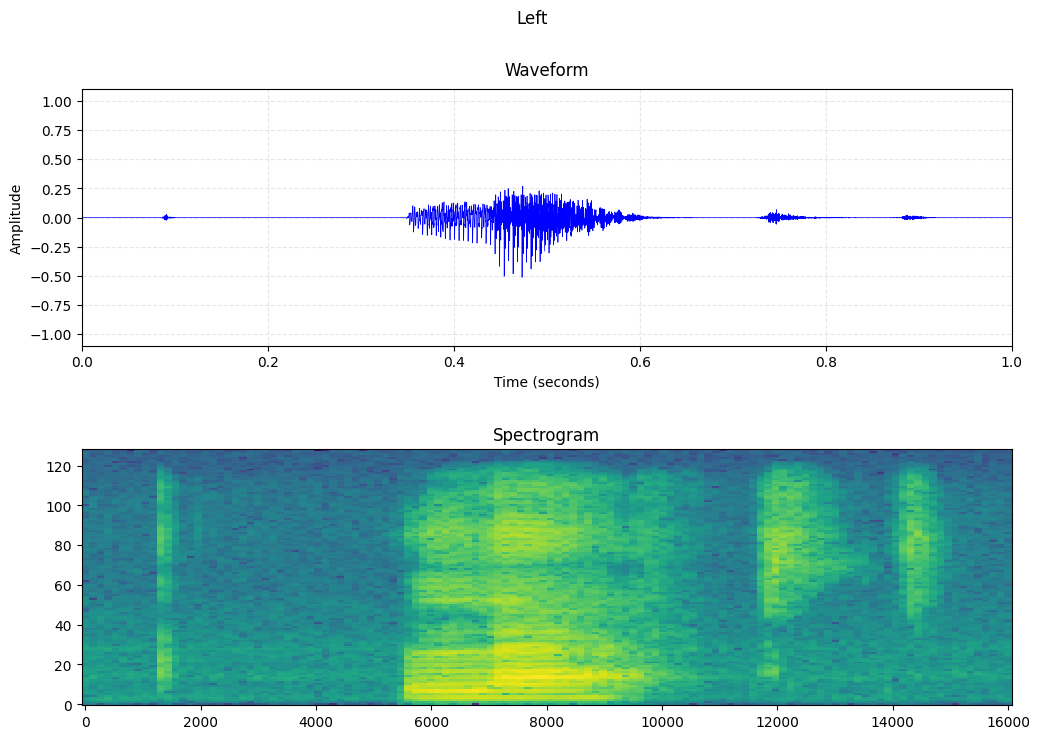

In [88]:
fig, axes = plt.subplots(2, figsize=(12, 8))

plt.subplots_adjust(hspace=0.4)

sample_rate = 16000
time = np.arange(waveform.shape[0]) / sample_rate

axes[0].plot(time, waveform.numpy(), 
             color='blue', 
             alpha=1.0, 
             linewidth=0.5)

axes[0].set_title('Waveform', fontsize=12, pad=10)
axes[0].set_xlabel('Time (seconds)')
axes[0].set_ylabel('Amplitude')
axes[0].grid(True, linestyle='--', alpha=0.3)
axes[0].set_xlim([0, len(waveform)/sample_rate])
axes[0].set_ylim([-1.1, 1.1])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

Now, create spectrogram datasets from the audio datasets:

In [89]:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [90]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

Examining the spectrograms for different examples of the dataset:

In [91]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

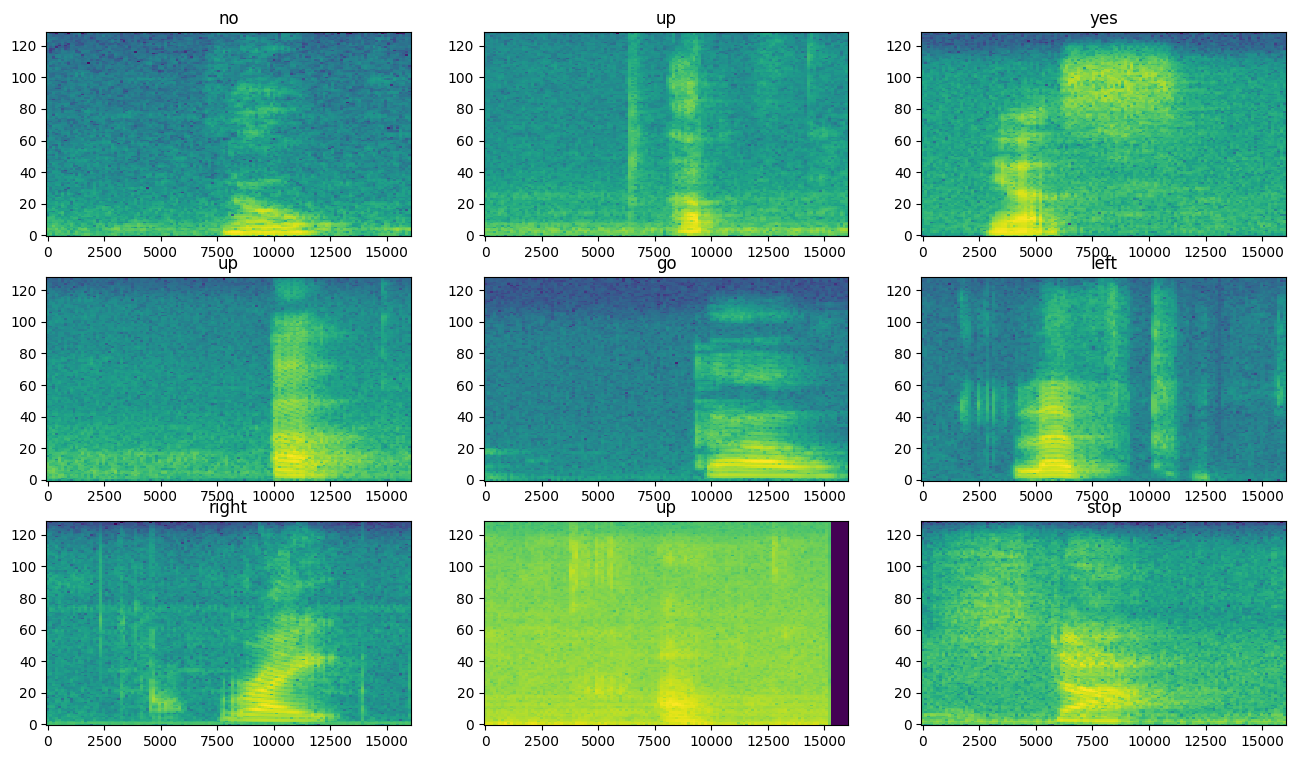

In [92]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(label_names[example_spect_labels[i].numpy()])

plt.show()

## Build and train the model

In [93]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

In [94]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Resizing(64, 64), # Resize to 64,64
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),  # Existing layer
    layers.Conv2D(64, 3, activation='relu'),  # Existing layer
    layers.MaxPooling2D(),                   # Existing layer
    layers.Dropout(0.25),                    # Existing layer
    layers.Conv2D(128, 3, activation='relu'),  # New Conv2D layer
    layers.MaxPooling2D(),                     # New MaxPooling2D layer
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (124, 129, 1)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing_2 (Resizing)           │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization_2 (Normalization) │ (None, 64, 64, 1)      │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 62, 62, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 60, 60, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,305,099 (12.61 MB)

 Trainable params: 3,305,096 (12.61 MB)

 Non-trainable params: 3 (16.00 B)

Configure the Keras model with the Adam optimizer and the cross-entropy loss:

In [95]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [96]:
EPOCHS = 20
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS
    #callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)


Epoch 1/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 24s 233ms/step - accuracy: 0.2893 - loss: 1.9041 - val_accuracy: 0.6901 - val_loss: 1.0521
Epoch 2/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 24s 237ms/step - accuracy: 0.6304 - loss: 1.0881 - val_accuracy: 0.8203 - val_loss: 0.6538
Epoch 3/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 24s 241ms/step - accuracy: 0.7524 - loss: 0.6965 - val_accuracy: 0.8424 - val_loss: 0.5000
Epoch 4/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 24s 241ms/step - accuracy: 0.8068 - loss: 0.5575 - val_accuracy: 0.8659 - val_loss: 0.4302
Epoch 5/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 25s 253ms/step - accuracy: 0.8624 - loss: 0.4223 - val_accuracy: 0.8802 - val_loss: 0.3989
Epoch 6/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 24s 237ms/step - accuracy: 0.8669 - loss: 0.3727 - val_accuracy: 0.8932 - val_loss: 0.3351
Epoch 7/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 23s 234ms/step - accuracy: 0.8941 - loss: 0.3061 - val_accuracy: 0.8802 - val_loss: 0.3635
Epoch 8/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 25s 247ms/step - accuracy: 0.9031 - loss: 0

## Final Cofiguration and Experimentation

We achieved optimal performance after 20 epochs by resizing the input to (64, 64) and adding an additional layer.

In addition to this configuration, we conducted several experiments to explore alternative approaches.
1. Replacing the Flatten layer with a global pooling layer.
2. Increasing the number of epochs to 12 and reducing batch size to 32, while keeping all other parameters unchanged.
3. Resizing the input layers to (64, 64).

## Experimentation Summary Table

| **Experiment**                            | **Epochs** | **Accuracy** | **Loss**  | **Validation Accuracy** | **Validation Loss** | **Conclusion**                                                                                           |
|-------------------------------------------|------------|--------------|-----------|--------------------------|----------------------|-----------------------------------------------------------------------------------------------------------|
| **Final Configuration**                   | 10         | 0.9197       | 0.2346    | 0.8945                   | 0.3380               | Optimal performance achieved.                                                                             |
| **Global Pooling Layer**                  | 10         | 0.4482       | 1.4653    | 0.4805                   | 1.4507               | Poor accuracy and high loss. Not effective.                                                              |
| **Increased Epochs (12), Batch Size = 32**| 12         | 0.9085       | 0.2628    | 0.8650                   | 0.4344               | Moderate improvement, but early stopping triggered. Not adopted.                                         |
| **Resized Input to (64, 64)**             | 10         | 0.9314       | 0.2103    | 0.8867                   | 0.4095               | Improved accuracy but high validation loss. Adding an extra layer addressed this, forming part of the final configuration. |

The original training and validation loss curves to check how your model has improved during training:

Text(0, 0.5, 'Accuracy [%]')

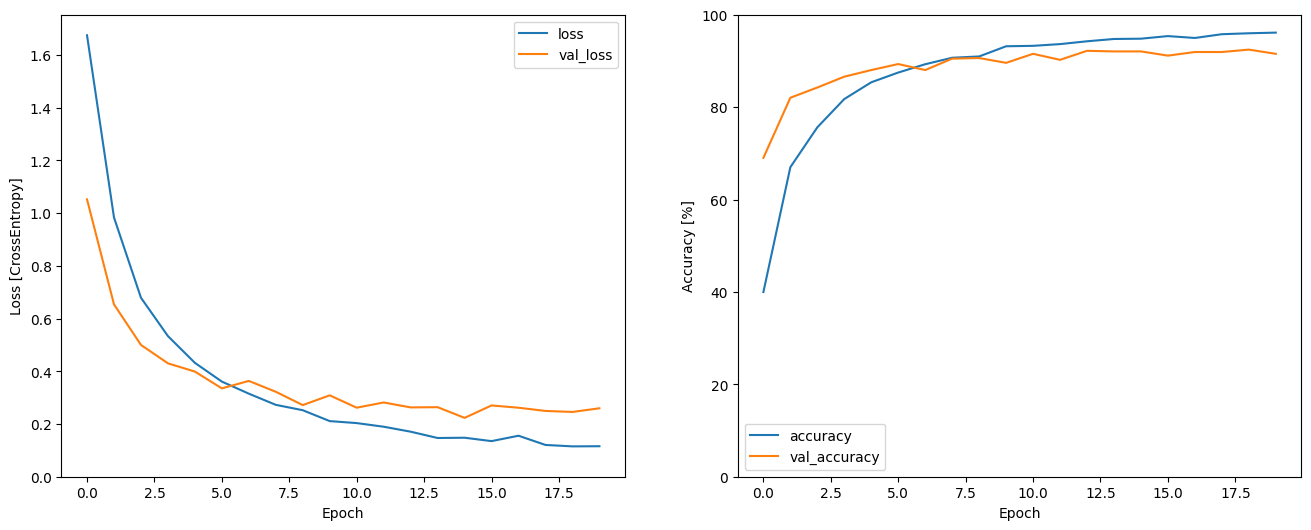

In [108]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

Text(0.5, 1.0, 'Accuracy After 10 Epochs With 1 Extra Layer and Resizing layer to (64,64)')

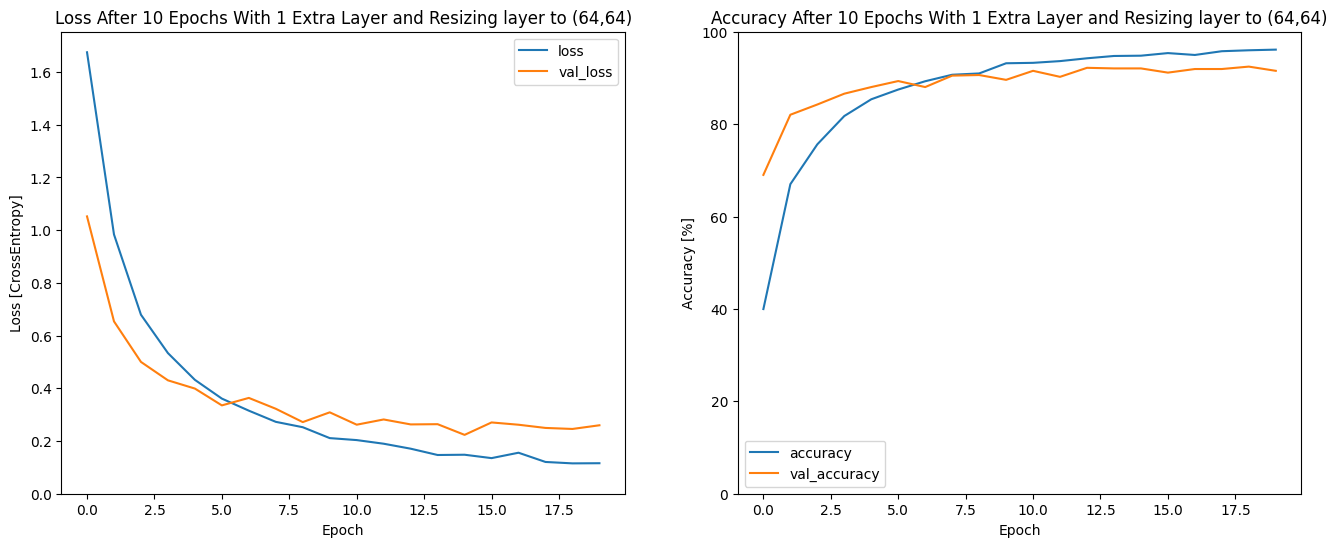

In [109]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.title("Loss After 10 Epochs With 1 Extra Layer and Resizing layer to (64,64)")

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

plt.title("Accuracy After 10 Epochs With 1 Extra Layer and Resizing layer to (64,64)")

## Evaluate the model performance

Run the model on the test set and check the model's performance:

In [110]:
model.evaluate(test_spectrogram_ds, return_dict=True)

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.8807 - loss: 0.3910


{'accuracy': 0.9038461446762085, 'loss': 0.333946168422699}

### Display a confusion matrix

Use a [confusion matrix](https://developers.google.com/machine-learning/glossary#confusion-matrix) to check how well the model did classifying each of the commands in the test set:


In [100]:
y_pred = model.predict(test_spectrogram_ds)

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step


In [101]:
y_pred = tf.argmax(y_pred, axis=1)

In [102]:
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

2025-01-08 22:58:19.290446: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


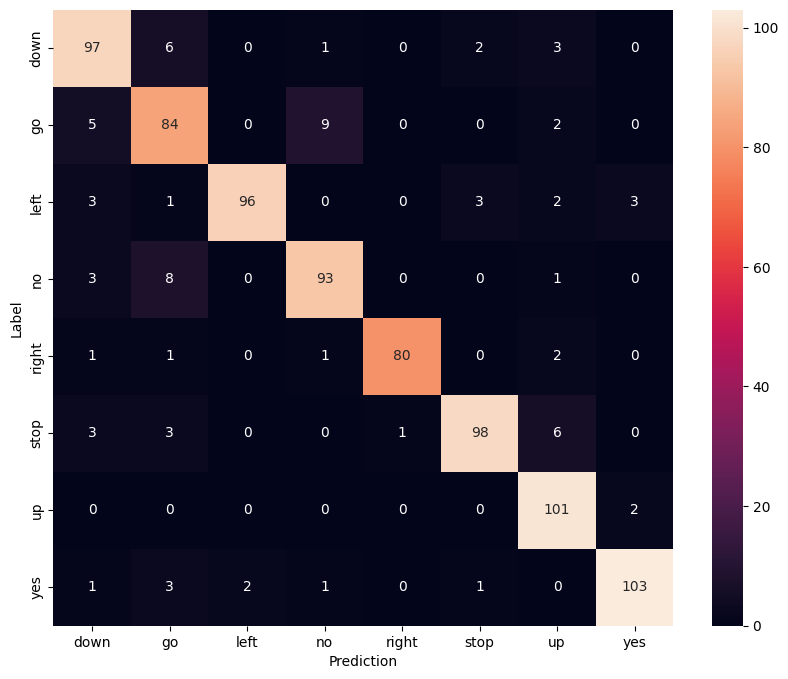

In [103]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()
# This showed the new prediction/label heatmap

## Run inference on an audio file

Finally, verify the model's prediction output using an input audio file of someone saying "no". How well does your model perform?

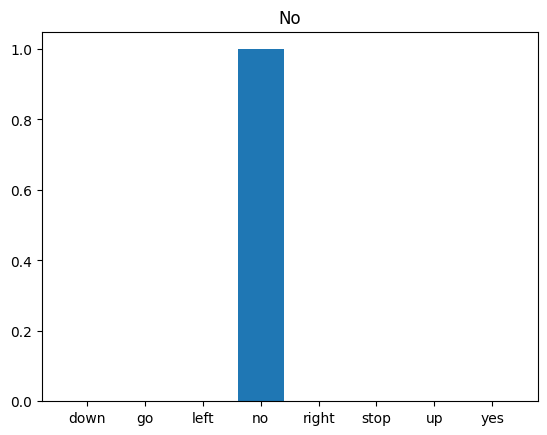

In [104]:
x_path = os.path.join(data_dir, 'no', '01bb6a2a_nohash_0.wav')

x = tf.io.read_file(str(x_path))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
x = tf.squeeze(x, axis=-1)
waveform = x
x = get_spectrogram(x)
x = x[tf.newaxis,...]

prediction = model(x)
x_labels = label_names.tolist()
plt.bar(x_labels, tf.nn.softmax(prediction[0]))
plt.title('No')
plt.show()

display.display(display.Audio(waveform, rate=16000))

The model has confidently recognized the audio command as "no".